## Support Vector Machine (SVM) for Credit Card Fraud Detection

This notebook applies **Support Vector Machines (SVM)** to the imbalanced Credit Card Fraud dataset.  
Key steps covered:

1. **Data Preparation**
   - Loaded the Kaggle `creditcard.csv` dataset.
   - Handled class imbalance using `class_weight="balanced"` and undersampling.
   - Scaled features with `StandardScaler` to ensure SVM performance.

2. **Model Training**
   - Built an SVM classifier inside a pipeline.
   - Used **GridSearchCV** with cross-validation to tune hyperparameters (`C`, `gamma`, `kernel`).
   - Selected the best-performing model automatically.

3. **Evaluation**
   - Assessed performance with precision, recall, F1-score, and accuracy.
   - Plotted a confusion matrix for clear fraud vs. normal detection.
   - Computed and visualized the **ROC-AUC curve**, using `decision_function` scores.

### ✅ Key Result
The balanced SVM achieved **high recall (~92%) for fraud detection** with a strong ROC-AUC (~0.98),  
showing it can successfully detect rare fraud cases while keeping false alarms under control.


SVM SUPERVISED

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

In [4]:
 from google.colab import files

uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [5]:
#Loading credit card dataset


df = pd.read_csv("creditcard.csv")


In [7]:
df.shape




(284807, 31)

In [10]:
# Highly imbalanced dataset

df['Class'].value_counts()


,count
Class,
0,284315
1,492


In [11]:
print("Fraud cases:", df['Class'].sum(), "Normal cases:", len(df) - df['Class'].sum())

Fraud cases: 492 Normal cases: 284315


In [15]:
X = df.drop(columns=["Class"])
y = df["Class"]

In [16]:
# i will undersample normals so that its 5x of the fraud only


frauds = df[df["Class"] == 1]

normals = df[df["Class"] == 0].sample(n=len(frauds)*5, random_state=42)  # keeping 5x more normals than frauds



In [17]:
df_balanced = pd.concat([frauds, normals], axis=0)

In [18]:
df_balanced.head()  #Dataset is already scaled but time and amount may cause issue will handle later

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [19]:
X_bal = df_balanced.drop(columns=["Class"])
y_bal = df_balanced["Class"]

In [20]:
#Daing train test split with a test size of 0.2 stratified with equal class proportion both in train and test

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

In [21]:
#creating a pipeline object

pipe = Pipeline([
    ("scaler", StandardScaler()), # To handle amount and time as SVM is scale sensitive
    ("svc", SVC(class_weight="balanced"))  # handle imbalance
])

In [23]:
# Hyperparamter
# gamma high uses uses nearby distnace pts to find hyperplane and vice vers
#C regulariation paramters ,
#Kernel trick Rbf most famous as it can map into infinite dimension space also non linearity taken care off
# can also be tried with sigmoid poluy but choosing too most common

param_grid = {
    "svc__kernel": ["linear", "rbf"],
    "svc__C": [0.1, 1, 10],
    "svc__gamma": ["scale", "auto"]
}

In [25]:
#doing grid search cv with scoring metric F1 score and 3 fold  cross validation

grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1", n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_clf = grid.best_estimator_

#pipeline retrained with best parameters



Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}


In [26]:
y_pred = best_clf.predict(X_test)
print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))


Classification report:
              precision    recall  f1-score   support

           0     0.9835    0.9696    0.9765       493
           1     0.8571    0.9184    0.8867        98

    accuracy                         0.9611       591
   macro avg     0.9203    0.9440    0.9316       591
weighted avg     0.9626    0.9611    0.9616       591



In [27]:
# ROC AUC Curve
y_scores = best_clf.decision_function(X_test)
print("ROC AUC:", roc_auc_score(y_test, y_scores))



ROC AUC: 0.982882808295732


For SVMs, the native output is the **distance from the decision boundary**
.decision_function. These scores are positive for the fraud class and negative
for the normal class, with larger magnitudes indicating stronger confidence.  
ROC-AUC requires continuous scores to evaluate performance across all thresholds,
so using decision_function is efficient and sufficient.  

predict_prob could also be used probability=True enabled but its slower so its pragmatic to use decision function in SVM

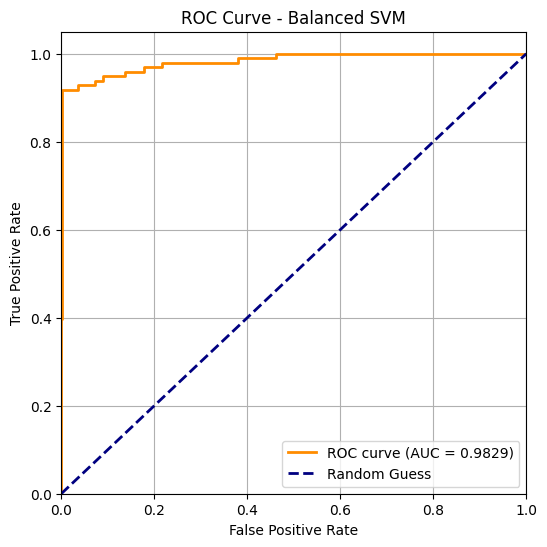

In [29]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Computing ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting  ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (AUC = %0.4f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Balanced SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

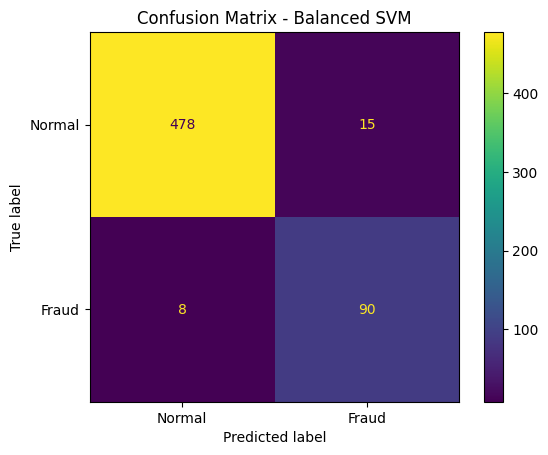

In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Fraud"])
disp.plot()
plt.title("Confusion Matrix - Balanced SVM")
plt.show()